## Hands-on #2: Structured Pruning with PLiNIO



In this notebook, you will:
1. Load the optimized DNN found at the end of Hands-on #1
2. Apply structured pruning with the PIT algorithm "on top" of this optimized DNN
3. Export and optionally fine-tune the pruned model.

Considering the flow seen in class, we are here:

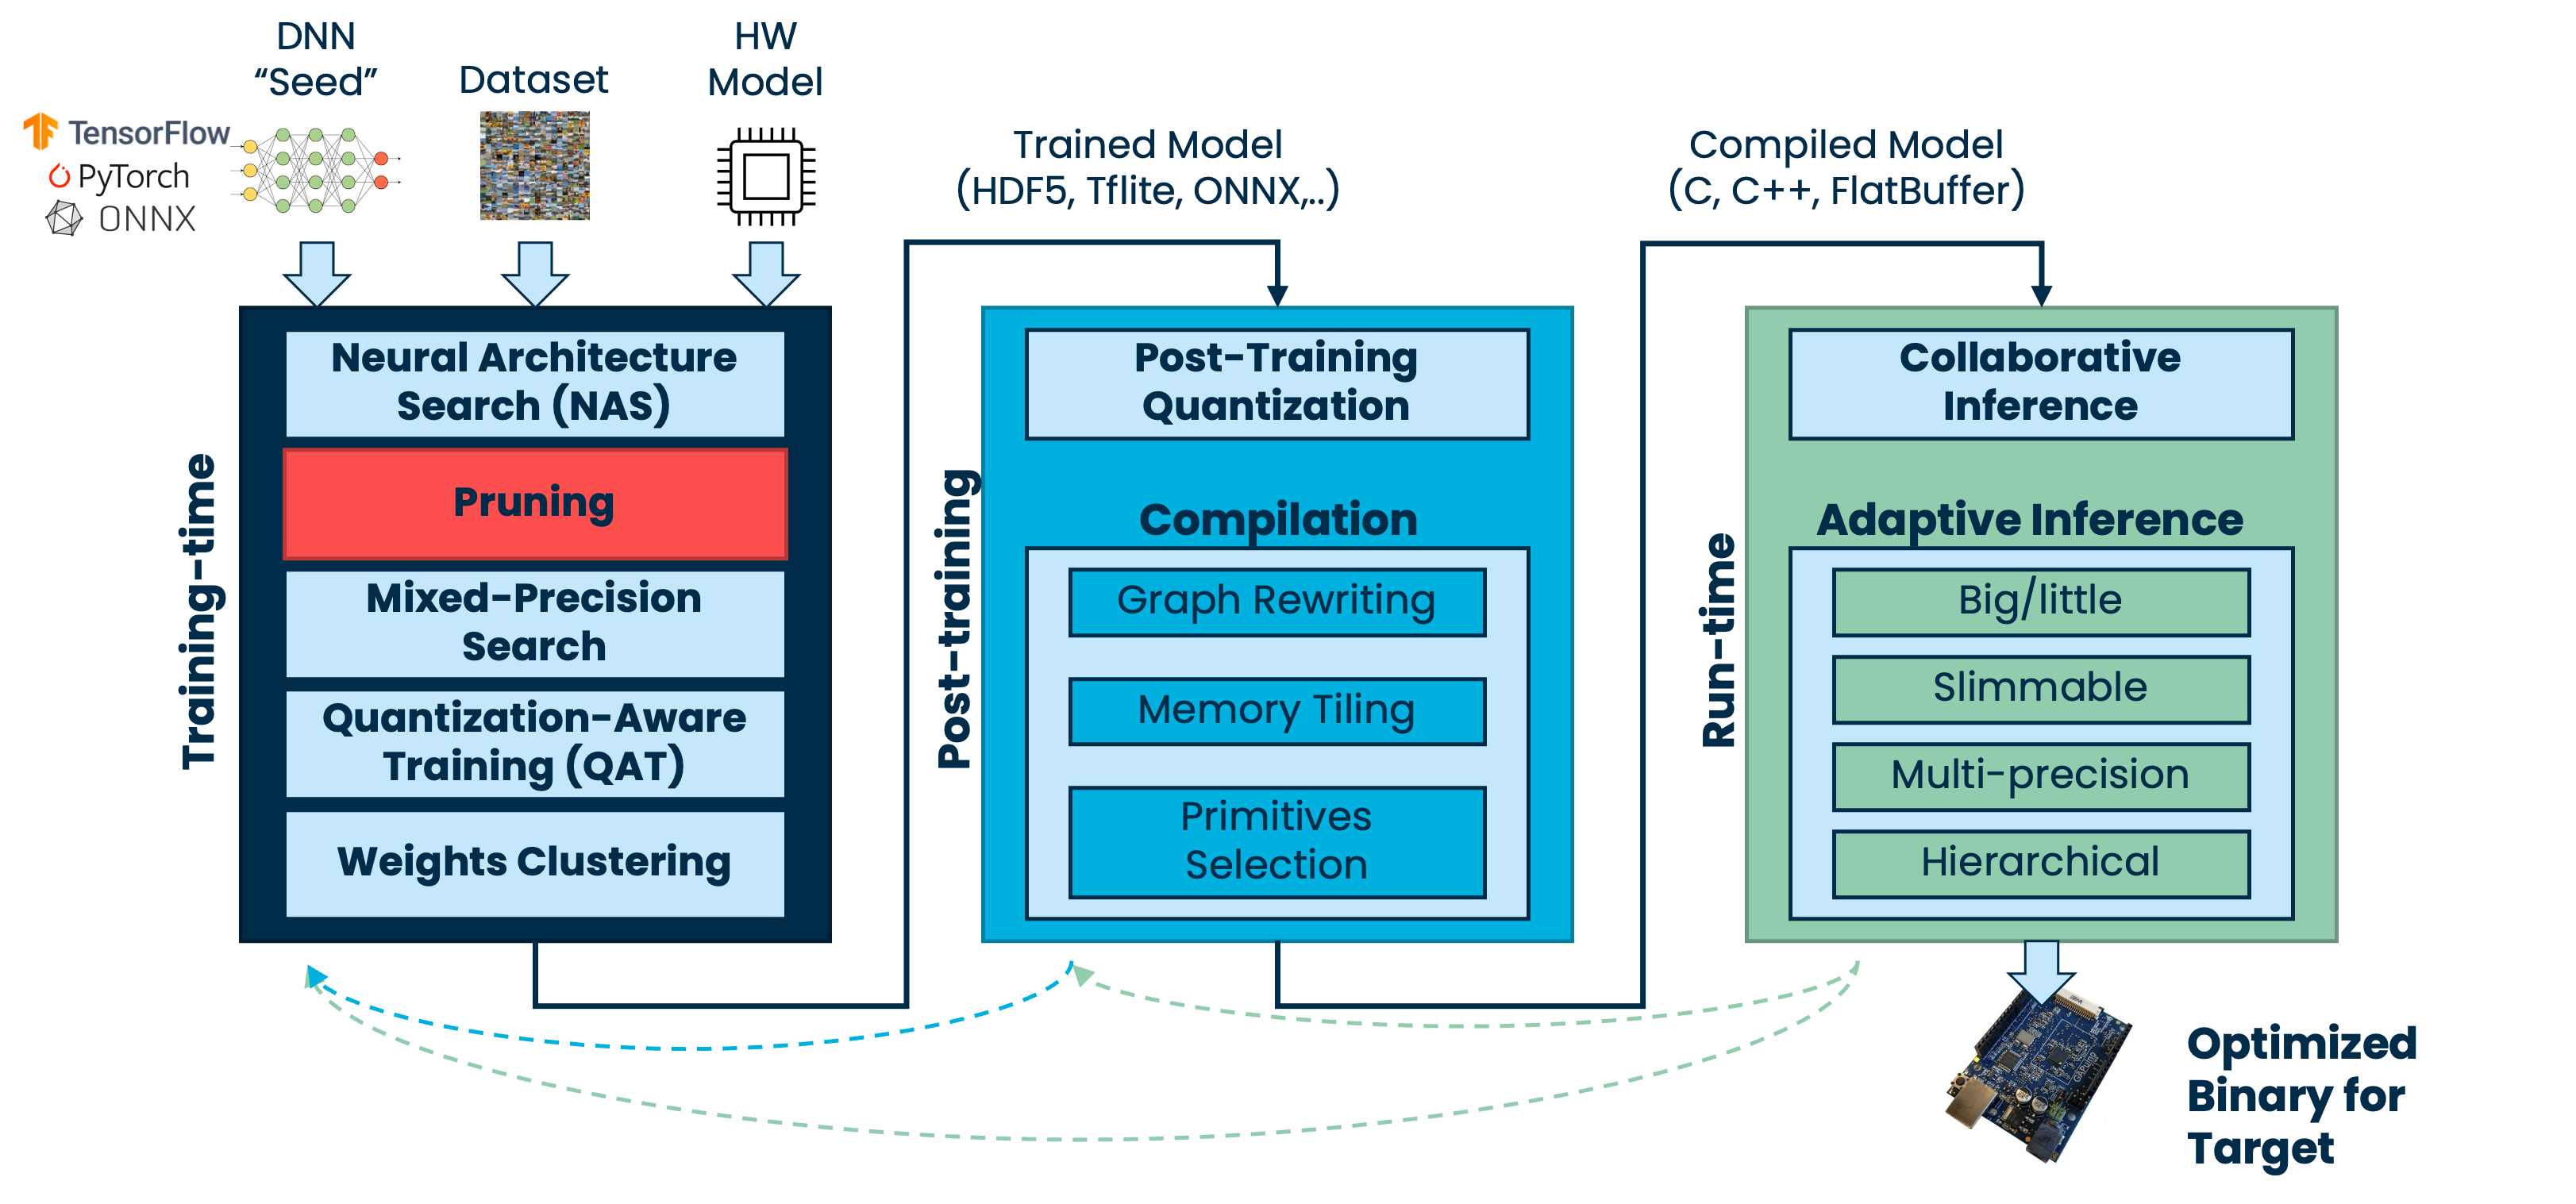

# Part 0: Initial Setup

## Setup for Kaggle or Google Colab

As done in notebook `I`, run the following code if in Kaggle or Colab, as explained before:

In [ ]:
#. !git clone https://github.com/eml-eda/oenne
#  %cd oenne

Moreover, you will also need to upload the `final_model.pt` file generated in notebook `I`.
- In Colab, you can simply Right-Click anywhere in the Files pane on the left, and select "Upload". Once the file has been uploaded, click on the three dots icon and select "Copy file path".
- In Kaggle, you will need to create a new private "dataset" to contain the file. In the Notebook options pane (on the right), under "Input" select "Upload" and drag-and-drop the `.pt` file. Then assign a name to your dataset and make it private. Once it appears, you can copy the path to the file by clicking on the rectangle icon.

In both cases, use the new file path instead of the default one in the `torch.load()` call below.

## Packages Installation

Install the required packages with pip if needed (**remember to re-comment these lines**):

In [ ]:
# standard Python libraries
#!pip install numpy pandas matplotlib seaborn torch torcheval torchinfo torchvision tqdm jupyterlab ipynb onnx
# the PLiNIO optimization library
#!pip install git+https://github.com/eml-eda/plinio.git@main#egg=plinio
# a helper library containing simple tinyML benchmarks and corresponding reference models
#!pip install git+https://github.com/eml-eda/pytorch-benchmarks.git@main#egg=pytorch-benchmarks

## Imports and Settings

As usual, we start by importing required libraries:

In [ ]:
import os
import sys
from pathlib import Path

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
from torchinfo import summary

from plinio.cost import params
from plinio.methods import PIT

import pytorch_benchmarks.image_classification as icl

from utils.train import set_seed
from utils.plot import plot_learning_curves_nas

And repeat the initial configurations (with some small parameters differences):

In [ ]:
SAVE_DIR = Path(f"experiments/02/")

TRAINING_CONFIG = {
    'in_class': False,          # kept for compatibility with hands-on #1. Leave it as false!
    'epochs': 50,               # max epochs for normal trainings
    'nas_epochs': 100,          # max epochs for the NAS search loop
    'nas_no_stop_epochs': 0,    # initial epochs without early stopping for the NAS
    'batch_size': 32,           # batch size
    'lr': 0.1,                  # initial learning rate for normal trainings
    'search_lr_net': 0.001,     # learning rate for DNN weights during NAS
    'search_lr_nas': 0.0005,    # learning rate for NAS parameters during NAS
    'weight_decay': 1e-4,       # weight decay for normal DNN parameters
    'patience': 10,             # early-stopping patience for normal trainings
    'nas_patience': 50,         # early-stopping patience for NAS search
}

set_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Working on: {device}")

# Part 1: Dataset Preparation

Dataset preparation is identical to the previous notebook:

In [ ]:
datasets = icl.get_data()
dataloaders = icl.build_dataloaders(datasets, batch_size=TRAINING_CONFIG['batch_size'])
train_dl, val_dl, test_dl = dataloaders

input_shape = datasets[0][0][0].numpy().shape
batch_shape = (1,) + input_shape

# Part 2: Structured Pruning with PIT

In Hands-on #1, we found DNN architectures that obtain good accuracy vs model size trade-offs for CIFAR 10 (within our limited search space). Now, we want to further reduce the size of one of these models, applying structured pruning with the PIT algorithm to eliminate some of the least important channels from each layer.

## The PIT Algorithm

For 2D CNNs, PIT works essentially as a channel-based pruning algorithm, and is described in details [here](https://arxiv.org/abs/2301.10281). During training, it learns to mask out unimportant channels for each layer, effectively eliminating them from the network. The working principle is schematized in the following picture:

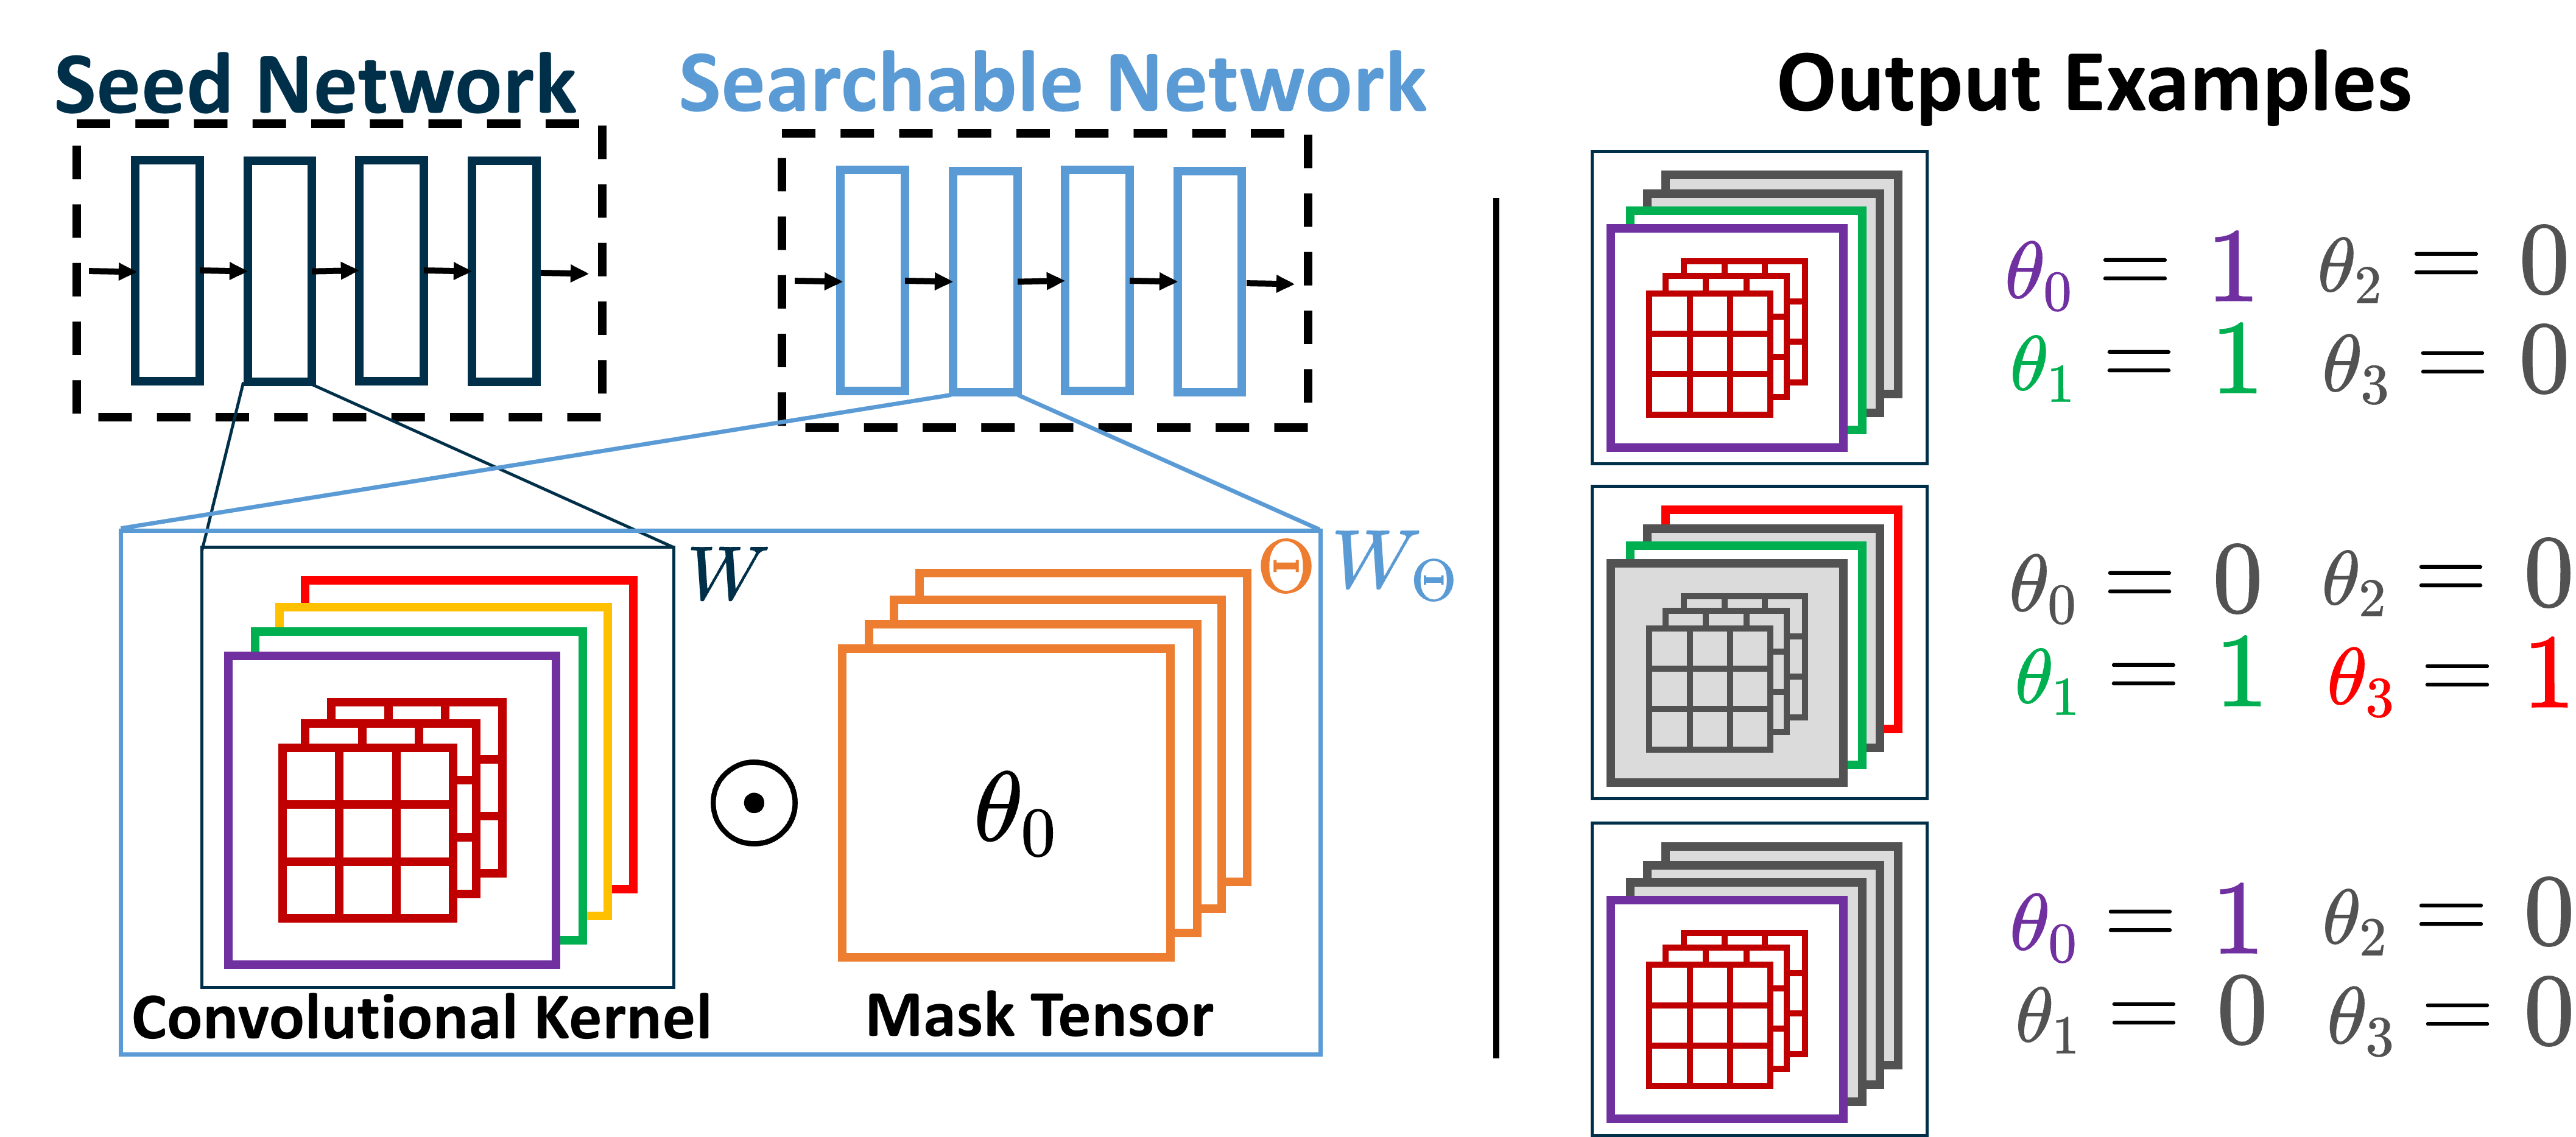

The "seed" DNN (a standard network) is turned into a "searchable" DNN by associating each supported layer (convolutional or linear) with a new set of trainable *binary* parameters $\theta$. Each $\theta_i$ is associated with a single weight filter/neuron, and functions as a mask. When it is set to $\theta_i=1$, the filter/neuron is kept, whereas, when it is set to $\theta_i =0 $ it is removed from the layer's output. Thus, the corresponding output activation channel is effectively eliminated. Notably, PIT can also optimize other parameters of 1D Convolutions (namely the kernel size and the dilation).

The $\theta$ values are trained with gradient-descent together with the normal weights of the network. In practice, what is actually trained are continuous parameters $\alpha$, from which $\theta$ binary masks are obtained through a step function ($\theta_i = \mathcal{H}(\alpha_i)$). Similarly to a SuperNet DNAS, the goal is to optimize a combined loss function in the form:

$$
\mathcal{L}_{tot}(W,\theta) = \mathcal{L}_{task}(W,\theta) + \lambda \mathcal{L}_{cost}(\theta)
$$

where $\mathcal{L}_{task}$ is the standard task-loss (cross-entropy in our case), while $\mathcal{L}_{cost}$ encodes the cost of the network. In fact, although PIT essentially implements channel pruning, it can also be considered a form of "mask-based DNAS". In the following, we will use model size (n. of parameters) as cost metric. 

## Importing the Model

Let's start by loading the final model from Hands-on #1:

In [ ]:
MODEL_PATH = Path("./experiments/01/final_model.pt")
model = torch.load(MODEL_PATH).eval()

Quickly verify that it's correctly loaded:

In [ ]:
criterion = nn.CrossEntropyLoss()
test_metrics = icl.evaluate(model, criterion, test_dl, device)
size = summary(model, batch_shape).total_params
print(f'Size: {size}, Test Loss: {test_metrics["loss"]}, Test Acc: {test_metrics["acc"]}')

## Preparing the Model

For the PIT algorithm, PLiNIO makes the optimization process much more transparent than for the SuperNet case. In fact, for the SuperNet, we had to manually define a multi-path DNN with multiple layer alternatives. In this case, instead, the input is a standard DNN (in our case, the optimized one from Hands-on #1). To make this model "optimizable", it suffices to pass it to the `PIT` class constructor from PLiNIO. The constructor internally implements the conversion steps necessary to generate the "searchable" network sketched in the figure above, replacing all Conv. and Linear layers with the respective mask-equipped versions, and handling all the necessary shape propagations to correctly estimate the DNN cost.

The parameters of the constructor are the same of SuperNet, with the addition of the optional `discrete_cost=True`, which ensures that cost is estimated using the discretized version of the masks (i.e. $\theta$, rather than $\alpha$).



### Getting an Initial Cost Estimate 

Let's call the constructor and get the initial cost estimate.

In [ ]:
nas_model = PIT(model, input_shape=input_shape, cost=params, discrete_cost=True)
nas_model = nas_model.to(device)
print(f"Estimated DNN cost: {nas_model.cost}")

Once again, you should have a cost that is *slightly lower* than the one computed by `torchinfo`. The reason is different from the SuperNet case: here, the reduction comes from the fact that, during the conversion implemented by the PIT constructor, Batch Normalization layers are folded with convolutions (as seen in class). This is necessary for the optimization to work.

### Looking at the Pruning Masks

Similarly to the SuperNet, we can look at the initial values of the PIT pruning masks:

In [ ]:
with torch.no_grad():
    for p in nas_model.nas_parameters(): 
        print((torch.abs(p)>0.5).int().cpu().numpy())

**Question**: Is the number of mask values expected? Why?

### Setting the Regularization Strength

Identically to the SuperNet case, we have to set the value of $\lambda$ for our combined loss function. Unfortunately, as mentioned before, there isn't a golden rule here. With the same rationale seen for the SuperNet, values around $10^{-6}$ will work fine, but some trial and error is required (or a more advanced regulatization method such as [DUCCIO](https://ieeexplore.ieee.org/abstract/document/10278089). 


In [ ]:
# results refer to using a 60k model from the SuperNet as starting point (obtained with lambda = 1e-6)
# TRAINING_CONFIG['reg_strength'] = 0 # (result around 83% acc - after fine-tuning, and 70k params - almost no pruning)
TRAINING_CONFIG['reg_strength'] = 1e-06 # (result around 83% acc - after fine-tuning, and 55k params)
# TRAINING_CONFIG['reg_strength'] = 1e-05 # (result around 76% acc - after fine-tuning, and 10k params)
# TRAINING_CONFIG['reg_strength'] = 1e-04 # (result around 54% acc - after fine-tuning, and < 1k params)

## Run the NAS Loop

For running the NAS optimization, we can reuse entirely the code seen in Hands-on #1. Thanks to the convenient `ipynb` library, we can load definitions (classes, functions, etc) defined in another Jupyter notebook. Let's use this functionality to load our NAS loop from Hands-on #1. Thanks to the transparent API of PLiNIO, this code, initially written for a SuperNet optimization, will work fine also for PIT. Clearly, to obtain optimal results, one would need to tweak with the parameters, which in some cases could require some code rewriting. However, for this basic example, reusing 100\% of the NAS loop will suffice.

The next cell runs the optimization:

In [ ]:
from ipynb.fs.defs.I_SuperNet import nas_loop

criterion = nn.CrossEntropyLoss()
history = nas_loop(SAVE_DIR / 'nas', TRAINING_CONFIG, nas_model, criterion, train_dl, val_dl, device)

Let's see what happened during the optimization:

In [ ]:
plot_learning_curves_nas(history)

### Evaluating the Pruned Model

Let's check the test accuracy of the pruned DNN after applying PIT.

In [ ]:
test_metrics = icl.evaluate(nas_model, criterion, test_dl, device)
print(f'Final model cost: {nas_model.cost}, Test Loss: {test_metrics["loss"]}, Test Acc: {test_metrics["acc"]}')

Depending on the regularization strength that you set, you should see that the cost (number of parameters) has reduced significantly once again, possibly at the cost of some accuracy degradation.

### Looking at the Masks (After the Search)

**Question:** Let's look again at the $\theta$ parameters. Have they changed? How? Which layers have been pruned the most? Is there one layer that *hasn't* been pruned at all? Which one and why?


In [ ]:
with torch.no_grad():
    for p in nas_model.nas_parameters(): 
        print((torch.abs(p)>0.5).int().cpu().numpy())

## Final Model Export (and Fine-Tuning)

As for the SuperNet, we can use the `model.export()` method to obtain a standard `nn.Module` after the optimization implemented by PIT:

In [ ]:
nas_model.train_net_and_nas()
final_model = nas_model.export()
final_model = final_model.to(device)

Let's look at the architecture of the optimized model using `torchinfo`.

In [ ]:
print(summary(final_model, batch_shape, depth=5))

**Question**: Look at the exported model summary. Does the number of channels in each layer match with the mask values printed above?


In case of the PIT algorithm, fine-tuning the exported model for some epochs is *more important* than for the SuperNet. This is because, in the same way that PIT *folds* BatchNorm layers before the search, it *unfolds* them when exporting the final model, to guarantee that it has exactly the same architecture of the input (except for the pruned channels).

You can verify this by testing the model just after export. You will see the accuracy drop significantly. However, few epochs of fine-tuning should suffice to recover the drop, and possibly even improve the final accuracy (thanks to BatchNorm). Let's run them.

In [ ]:
from ipynb.fs.defs.I_SuperNet import training_loop

criterion = nn.CrossEntropyLoss()
history = training_loop(SAVE_DIR / 'finetune', TRAINING_CONFIG, final_model, criterion, train_dl, val_dl, device)

Finally, let's evaluate our optimized model on the test set:

In [ ]:
test_metrics = icl.evaluate(final_model, criterion, test_dl, device)
print(f'Test Loss: {test_metrics["loss"]}, Test Acc: {test_metrics["acc"]}')

**Question:** Considering SuperNet and PIT combined, by how much did you manage to compress the model size? At what cost in terms of accuracy?

## Saving the Final Model

Let's save the model in a separate location to reuse it more easily in later sessions:

In [ ]:
torch.save(final_model, SAVE_DIR / f'final_model.pt')

## Note for Kaggle and Colab Users

As for notebook `I`, if you are on Kaggle or Colab, make sure you download the `final_model.pt` file to your local machine before closing the session.